<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [29]:
%%capture
pip install pyswarms

In [30]:
%%capture
!pip install numpy==1.26

In [31]:
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 20000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

In [34]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [35]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [36]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [37]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [38]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [39]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [40]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [41]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [42]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario01.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario02.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario03.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario04.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [43]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [44]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [54]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-10-27 17:54:48,662 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-2.17e-24
2023-10-27 17:54:48,923 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.1742554956207226e-24, best pos: [124.70453599   1.99912398   0.23339115]


In [56]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 124.70453598647626
beta: 1.9991239843204789
theta: 0.23339114920679804

Tempo de Convergência para a primeira etapa: 0.01893329620361328 segundos


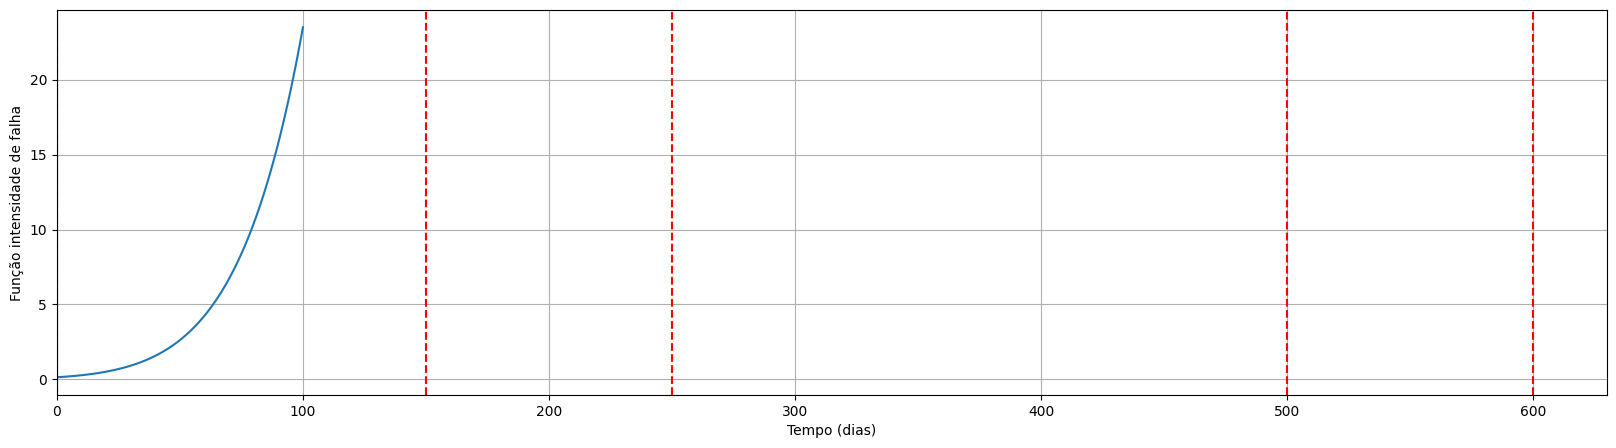

Fator ajuste:  [0.12593593864412922, 0.15485917743198108, 0.26129278020855595, 0.06508606740734102]


In [47]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [48]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [57]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-27 18:01:13,802 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=2.78e+3



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 83, 268, 397, 425, 456, 507, 542, 595, 636]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636]
Media de falhas:  [0, 0.4431457274959492, 4.487119701624862, 9.283758935998453, 10.604479829734329, 12.08651953918437, 14.760434482160752, 16.751791422389456, 20.214091956779882, 22.951135882375734, 20.418608168079512]
Custo =  3415.4620533458606


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 113, 201, 309, 381, 449, 475, 481, 523, 559, 644, 699]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.16057937889727636, 0

pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=2.54e+3

5
Tempos para manutenções preventivas: [0, 8, 44, 77, 97, 164, 238, 374, 474, 499, 608]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001]
Media de falhas:  [0, 0.004125345978943973, 0.12219440749231597, 0.36842913840240343, 0.5809634147027594, 1.6575829418506423, 3.3972200756960698, 8.285189879194816, 12.959314566109047, 14.276824448244236, 20.901962613220473, 20.38184913313311]
Custo =  2535.1658308179112


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 53, 90, 199, 238, 283, 365, 471, 491, 616, 654]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.0566781849687200

pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=2.54e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 58, 89, 157, 186, 274, 367, 390, 475, 491, 514, 608, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.018616218791185957, 0.2106294187144688, 0.4905712602765355, 1.521713830676944, 2.0964877977054246, 4.35952610507724, 7.66284529169778, 8.60692224877035, 12.644617528692175, 13.581620243982368, 14.832889036762557, 20.60771019709369, 26.02012517903215, 19.761384228236082]
Custo =  4428.701480917814


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 18, 151, 279, 345, 372, 4

pyswarms.single.global_best:  52%|█████▏    |52/100, best_cost=2.54e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 6, 55, 72, 343, 369, 390, 473, 486, 613, 678]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915]
Media de falhas:  [0, 0.002321091987145075, 0.19219696807993983, 0.32423873806388703, 7.407294815358848, 8.470018573823609, 9.437150360246893, 13.369191134889308, 14.124857581243685, 21.81289065892545, 26.378141297933016, 20.36451078337165]
Custo =  4021.115975557298


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 5, 55, 354, 365, 472, 496, 513, 613, 644, 665]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.065086

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=2.54e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 12, 102, 175, 192, 223, 295, 346, 371, 398, 473, 502, 524, 613, 643, 684]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001]
Media de falhas:  [0, 0.009278732119191772, 0.660097146166106, 1.9054777328335348, 2.264282338955118, 2.9681056899197253, 5.0328244624756815, 7.022880510202976, 7.99570255227656, 9.187363376954082, 12.766545361477053, 14.482026447497363, 15.703543728612122, 21.23849148661063, 23.39716101625365, 26.69744138397895, 20.958294529603542]
Custo =  5808.058877963182


pyswarms.single.global_best:  80%|████████  |80/100, best_cost=1.87e+3



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 12, 50, 89, 293, 370, 473, 529, 605, 640]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915]
Media de falhas:  [0, 0.009278732119191772, 0.1570709435161227, 0.49147967830433004, 5.366125305411281, 8.480536911784188, 13.270331894242087, 16.326887781689784, 21.03090894395703, 23.52862057356112, 20.5311361316801]
Custo =  2261.21827098435


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 15, 51, 81, 185, 291, 371, 473, 534, 607]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.0566781

pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=1.87e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 15, 67, 200, 239, 240, 368, 404, 472, 537, 611, 682]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.014495185180345305, 0.2822888150533537, 2.499685238343481, 3.489304480328641, 3.515148017127724, 8.289923871818061, 9.88726067805526, 13.145793399273387, 17.133067398831827, 21.767555526526287, 27.04688988484726, 20.70621802400413]
Custo =  6686.89543334889


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 59, 71, 193, 359, 368, 400, 472, 534, 611, 689]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.7

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.87e+3
2023-10-27 18:01:15,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747886 2.40861592 4.29081998 2.33273981 4.63819023 0.66130455
 5.42758738 3.7443416  3.03053597 3.48903742 6.50993018 0.33615263
 5.1898718  1.73290993 6.44795998 5.75227589 5.05916029 3.82930373
 6.43752221 2.56289725 1.70866934 2.11669815 1.73395505 2.84794524]
2023-10-27 18:01:15,323 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 15, 58, 193, 227, 297, 367, 473, 532, 610]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.014495185180345305, 0.21106443067540107, 2.33192889475222, 3.2016143009731794, 5.2301665403259445, 7.786677974925571, 12.9538920767794, 16.185546383009974, 21.048562151528785, 20.35808420252578]
Custo =  2245.8635515161823


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 15, 57, 76, 188, 228, 357, 367, 473, 532, 610, 632]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.056

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55778422 2.40902135 4.21311628 2.33239976 4.63824919 0.66130448
 5.4274615  3.74336549 2.87179947 4.13090131 6.5098057  0.3348401
 5.18998899 1.73309513 6.44141932 5.7524479  5.05931286 3.82885939
 6.4375433  2.56422501 1.71154322 2.11678192 1.73472325 2.84797537]
2023-10-27 18:01:15,349 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 57, 71, 181, 340, 369, 396, 473, 535, 616, 657, 687]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.20357570518662496, 0.31301176710903367, 2.0378049209811877, 7.149439691250869, 8.266611726151687, 9.452106266069933, 13.120025639619838, 16.91884412168437, 22.01065272691706, 25.003797994378573, 27.44828964116949, 21.10613870618868]
Custo =  3496.3352061610444


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55784524 2.40925047 4.21814412 2.33226706 4.63826437 0.66130805
 5.42753881 3.74209043 2.83736119 1.00692466 6.50970592 0.33451155
 5.1899075  1.73314061 6.44102677 5.75236251 5.05845709 3.83156043
 6.43755862 2.56182093 1.71073712 2.11685732 1.73375703 2.84793267]
2023-10-27 18:01:15,365 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 17, 182, 272, 370, 401, 472, 536, 618, 649, 685]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.018616218791185957, 2.105831723714058, 4.611553136303179, 8.102797248955651, 9.401180028982331, 12.794194408971048, 16.716020614867737, 21.884780734262236, 24.135085893345835, 27.04748328479762, 20.859629714883248]
Custo =  2997.572664958498


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5578017  2.40939459 4.23095736 2.33226282 4.63826905 0.66131126
 5.4276218  3.74152943 2.84741198 4.97820857 6.50962229 0.33453702
 5.18982568 1.73312499 6.44086381 5.75228018 5.05775618 3.8339246
 6.43756434 2.55987449 1.70977197 2.11689738 1.73288768 2.84789633]
2023-10-27 18:01:15,382 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 81, 185, 226, 270, 370, 406, 472, 536, 620, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.018616218791185957, 0.4129522317804909, 2.1296053721443378, 3.104975039604664, 4.301895541109956, 7.855675988615279, 9.375024858467569, 12.543467573277207, 16.465293779173898, 21.770896829209807, 26.487770355301823, 20.065053869005297]
Custo =  3221.0641916589743


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55774822 2.40930035 4.24512126 2.3323345  4.63827239 0.66131407
 5.42769148 3.74178694 2.89490364 1.25456552 6.50961653 0.33484135
 5.18975514 1.73308304 6.44182921 5.75220583 5.0572248  3.83560565
 6.43755688 2.55821775 1.70862866 2.11689211 1.7321675  2.84786817]
2023-10-27 18:01:15,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 17, 190, 368, 411, 472, 480, 537, 622, 680, 690]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915]
Media de falhas:  [0, 0.018616218791185957, 2.295912012191663, 8.429378448652269, 10.254205357715602, 13.195898582667468, 13.657390042891281, 16.815155012061577, 22.198525094594086, 26.53568537303913, 27.36551712234695, 20.36530423878025]
Custo =  4686.763651711131


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55764439 2.40916584 4.2630745  2.33244233 4.63826073 0.66131638
 5.42773678 3.7423378  2.96226526 4.49127307 6.50967105 0.33543594
 5.18971705 1.7330256  6.44290467 5.75214458 5.05723929 3.83547761
 6.43754248 2.55742692 1.7076079  2.11686096 1.73178457 2.84784347]
2023-10-27 18:01:15,418 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 77, 195, 255, 367, 417, 472, 481, 537, 623, 645, 678, 692]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915]
Media de falhas:  [0, 0.018616218791185957, 0.37288257315418843, 2.369512643760237, 3.8628501215320155, 7.748327345285543, 10.006053419322454, 12.672772562178496, 13.192527776957213, 16.297332075618762, 21.749551986514753, 23.34639970516537, 25.993778338049324, 27.1557463139403, 19.989511029383944]
Custo =  5342.829105079484


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55754406 2.40902523 4.28527205 2.33258037 4.63823005 0.66131844
 5.42775768 3.74315402 3.02297058 0.39801994 6.50972315 0.33617611
 5.18970595 1.73295619 6.44416963 5.75212679 5.05732721 3.83357359
 6.43752851 2.5577448  1.70671725 2.11679402 1.7320569  2.84783342]
2023-10-27 18:01:15,435 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 199, 214, 240, 286, 355, 366, 471, 482, 536, 624, 677, 691]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915]
Media de falhas:  [0, 0.01649136718820338, 2.5209621479821136, 2.8972520005682143, 3.5408583621998333, 4.938964642835674, 7.5004963761715215, 7.954596992854259, 13.054338620141609, 13.620609313368515, 16.613415357919763, 22.194243565065587, 26.15261439843874, 27.312888595530783, 20.229721368516905]
Custo =  5938.991432170774


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55744269 2.40887318 4.3055714  2.33271041 4.63819062 0.66131915
 5.42774028 3.74411183 3.07942053 3.56776211 6.50978091 0.33683603
 5.18970257 1.73288381 6.44597607 5.75211785 5.05794573 3.83127956
 6.43751441 2.55946682 1.70597785 2.11672478 1.73235346 2.84785792]
2023-10-27 18:01:15,454 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 168, 201, 274, 364, 472, 482, 535, 624, 677, 690]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915]
Media de falhas:  [0, 0.01649136718820338, 1.794093281382547, 2.536160677240192, 4.656890602810879, 7.836324756130388, 13.077896204056115, 13.593123246090062, 16.527107098837387, 22.167478407878047, 26.1258492412512, 27.2024130648182, 20.2022001812515]
Custo =  4614.5941294354525


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 201, 221, 357, 363, 472, 483, 534, 624, 677]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.572093851496784, 3.085077304507423, 7.5144077186402445, 7.776241043297255, 13.06089264740304, 13.628348078584933, 16.450564964645853, 22.150392283637288, 26.10876311701044, 20.17660864940124]
Custo =  5581.363095608537



2023-10-27 18:01:15,469 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55735227 2.40867723 4.31959513 2.33283164 4.63815513 0.66131605
 5.42771716 3.74501055 3.12903453 6.41221134 6.50985926 0.33736588
 5.18972838 1.73282298 6.44792213 5.75212448 5.05877961 3.82907572
 6.43750211 2.5619381  1.70585548 2.1166562  1.7328527  2.84789728]
2023-10-27 18:01:15,470 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55728744 2.40848653 4.32393851 2.33291358 4.63812541 0.66131132
 5.42769274 3.7456459  3.16145815 1.61220248 6.50993368 0.33780074
 5.18977705 1.73278896 6.44968335 5.75214849 5.05962102 3.82716036
 6.43749328 2.56431359 1.70587376 2.11660532 1.73344128 2.84794186]
2023-10-27 18:0



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 70, 201, 225, 363, 472, 483, 533, 624, 678]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.30801726683128466, 2.5228619459326547, 3.0802527153594785, 7.651908887517351, 12.936560491623137, 13.50401592280503, 16.267687802697512, 22.026884039546662, 26.063404227372278, 20.04977371281091]
Custo =  3807.4973998298665


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55727521 2.40832204 4.32530517 2.33293969 4.63810179 0.66130686
 5.42766244 3.74615956 3.15688631 3.82825662 6.51000039 0.33785724
 5.18984765 1.73278819 6.45115855 5.75219932 5.06028738 3.82560771
 6.43749099 2.56610983 1.70609731 2.11658594 1.73409735 2.84798215]
2023-10-27 18:01:15,503 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 200, 223, 349, 363, 416, 472, 483, 533, 623, 633, 680]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.546463806854927, 3.1380385020258856, 7.187974554602325, 7.727397562601797, 10.106580682071504, 12.819346616869069, 13.456014219375252, 16.219686099267737, 21.909821840904517, 22.627965607180613, 26.37243360056837, 20.19550984426629]
Custo =  5701.862505831265


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,517 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55727492 2.40819768 4.32060758 2.33292991 4.6380975  0.66130224
 5.42761533 3.74627039 3.12994377 5.76389768 6.51004831 0.33788548
 5.18991564 1.73281003 6.45210227 5.75226545 5.06078913 3.82499684
 6.43749582 2.56760082 1.70701143 2.1165736  1.73467844 2.84800966]
2023-10-27 18:01:15,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 88, 197, 363, 411, 472, 483, 533, 622, 650, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.48848093046891106, 2.415100751609636, 7.923518071828958, 9.950080034261674, 12.89177325921354, 13.528440861719723, 16.292112741612208, 21.913316262098437, 23.95324643451999, 26.454954997490812, 20.19621404669474]
Custo =  4130.05686415915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,535 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55729831 2.40812235 4.31403922 2.33290218 4.63811594 0.6612987
 5.42756839 3.74624475 3.08351157 0.34390165 6.51005644 0.33773518
 5.18997639 1.73285224 6.45266615 5.75232774 5.06092536 3.82495404
 6.43750095 2.56876574 1.70829242 2.1165673  1.73517446 2.84802699]
2023-10-27 18:01:15,537 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 73, 194, 363, 406, 472, 483, 533, 621, 682]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.335203423255362, 2.3472630205454292, 7.929855894375072, 9.7315224754774, 12.899965190287038, 13.53663279279322, 16.300304672685705, 21.852704246292493, 26.41897409317296, 20.078302232329833]
Custo =  3694.196427665937


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55733094 2.40812565 4.30210759 2.33285221 4.63815383 0.66129605
 5.42752837 3.74584087 3.03841325 2.42299359 6.51005707 0.33746404
 5.19000002 1.7328997  6.4520561  5.75237075 5.06088786 3.82606647
 6.43750593 2.56959532 1.7094637  2.11657014 1.73545813 2.84802462]
2023-10-27 18:01:15,551 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 60, 191, 220, 246, 338, 364, 404, 472, 482, 533, 620, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.22574982837498528, 2.2818721851582717, 2.9693077405947346, 3.6297264651344685, 6.915898803303975, 7.963776744971442, 9.636354905273917, 12.894887626492045, 13.4730348887806, 16.28975923455128, 21.773483135759417, 26.490356661851433, 20.067640175554907]
Custo =  4916.528948274996


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 159, 188, 254, 275, 365, 402, 472, 482, 534, 620, 630, 684]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.606178978595034, 2.2192376723825267, 4.003052893409139, 4.606671960383562, 7.956014897294633, 9.58742103965253, 12.935695313760103, 13.513842576048658, 16.389132529120506, 21.813569905293015, 22.528289421062155, 26.83508445751848, 20.724229561806826]
Custo =  5349.513348511617


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55737366 2.40823299 4.29122715 2.33279111 4.6381942  0.66129568
 5.42750237 3.74522469 2.99735267 4.54497946 6.51004792 0.33706235
 5.19001691 1.73294428 6.45070247 5.75238747 5.0603712  3.82728236
 6.43751085 2.56942167 1.71039104 2.11659008 1.73536112 2.84801725]
2023-10-27 18:01:15,650 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,708 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55742911 2.40839129 4.28139637 2.33272983 4.63823018 0.66129548
 5.42749765 3.74462168 2.96241156 6.39921622 6.51001467 0.33663577
 5.19000881 1.73298367 6.44894241 5.75237283 5.05982517 3.82894715
 6.437518   2.56



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 187, 232, 261, 283, 355, 366, 402, 472, 481, 534, 619, 633, 684]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.224956540712379, 3.375085852482011, 4.15479444009526, 4.84233886643005, 7.504433315586601, 7.958533932269338, 9.547649062439397, 12.895923336546971, 13.415678551325689, 16.343954471678426, 21.699865048432933, 22.702465933330974, 26.778694192111665, 20.66783929640001]
Custo =  6383.40958776003


2023-10-27 18:01:15,714 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 59, 62, 187, 266, 290, 367, 403, 472, 481, 535, 619, 635, 683]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.21822992876476938, 0.24028736237537573, 2.18436815231641, 4.274492116411627, 4.999997517964419, 7.9332221121707365, 9.52644808502853, 12.829895139479927, 13.349650354258644, 16.33664077537372, 21.63319833331636, 22.7810802244234, 26.619910775262255, 20.585954548026045]
Custo =  6366.549423887022


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748866 2.40859832 4.27330343 2.33267724 4.6382553  0.66129618
 5.42749571 3.74404706 2.94044772 0.60506684 6.50997746 0.33619753
 5.18997236 1.73301701 6.44716634 5.75233671 5.05927292 3.83053295
 6.43752472 2.56775117 1.71086162 2.11665747 1.73450545 2.84796392]
2023-10-27 18:01:15,807 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,839 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55754083 2.40878573 4.27003592 2.332647   4.63826597 0.66129739
 5.42750144 3.74361592 2.93250802 1.97197823 6.50993741 0.33580101
 5.18993013 1.73303961 6.44570065 5.7522875  5.05874498 3.83171432
 6.4375304  2.56



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 16, 59, 79, 179, 188, 229, 268, 295, 338, 367, 406, 472, 481, 535, 619, 637, 683]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.21822992876476938, 0.3871270123909421, 1.9878381278495165, 2.177284401802096, 3.1167924984054607, 4.177791098592537, 5.005002099998925, 6.573774902051021, 7.748144308177924, 9.579843875183913, 12.748286589993551, 13.268041804772269, 16.255032225887344, 21.551

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,871 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55757822 2.40890773 4.27055708 2.33262109 4.63825803 0.66130055
 5.42753119 3.74323653 2.93038363 3.56707763 6.5099012  0.33553811
 5.18988633 1.73302707 6.44475055 5.75224146 5.05833627 3.83257566
 6.43753541 2.56329229 1.71014781 2.11673124 1.73351054 2.84791019]
2023-10-27 18:01:15,874 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 189, 266, 352, 367, 408, 472, 480, 536, 619, 631, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.2730069026735684, 4.417815074296814, 7.359739774128718, 7.9776789600770845, 9.805339279836357, 12.883343536292278, 13.344834996516092, 16.443608279989494, 21.680725727203264, 22.538558679780937, 26.602446130805042, 20.64528856618653]
Custo =  5712.555881037296


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,904 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55758639 2.40897915 4.27486763 2.33259837 4.63824532 0.66130377
 5.42756123 3.74322504 2.94271214 4.98749707 6.50987334 0.3354734
 5.18984648 1.73299573 6.44442295 5.75220011 5.05799249 3.83272795
 6.43753942 2.56129868 1.70950204 2.1167597  1.7331352  2.84789573]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 190, 256, 366, 411, 472, 480, 536, 619, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.2972246722029355, 4.097025509434399, 7.910852886495588, 9.923231891190879, 12.864925116142743, 13.326416576366556, 16.42518985983996, 21.66230730705373, 26.293257149035504, 20.034516198239437]
Custo =  4196.335385415442


2023-10-27 18:01:15,906 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,921 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55756804 2.40894576 4.2813562  2.33260621 4.63823356 0.66130674
 5.42758925 3.74338397 2.97169016 6.01381493 6.50986262 0.33542812
 5.18981813 1.73296742 6.44443392 5.75217808 5.05788871 3.83222394
 6.437539   2.55955355 1.70891178 2.11677191 1.73282942 2.84788425]
2023-10-27 18:01:15,922 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 63, 192, 236, 247, 366, 414, 472, 481, 535, 620, 680]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.24908065547100144, 2.3041361328609433, 3.339831718947554, 3.6276153597406173, 7.706820025962094, 9.862596684287402, 12.667194869634088, 13.186950084412805, 16.17394050552788, 21.53900426459331, 26.019721087495377, 19.842797331193296]
Custo =  5007.302655620526


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,935 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55754518 2.40888668 4.28768666 2.33263832 4.63821503 0.66130928
 5.42761426 3.74368074 3.01121607 6.48871447 6.5098641  0.33555582
 5.18980099 1.7329286  6.44475004 5.75215932 5.05807251 3.83136852
 6.43753629 2.55888725 1.70837616 2.11676931 1.73259689 2.8478874 ]
2023-10-27 18:01:15,936 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 69, 171, 193, 221, 299, 366, 416, 472, 481, 535, 621, 652, 679]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.2992122225286384, 1.821448248132038, 2.258426162850098, 2.8917628032490343, 5.141768886975655, 7.590253887522723, 9.842270556591549, 12.555036491389114, 13.074791706167831, 16.061782127282907, 21.495480362229532, 23.756400554733368, 25.93491551491661, 19.839695237408495]
Custo =  5990.358153375997


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,949 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55750538 2.40878917 4.29366596 2.33269697 4.63819728 0.66131122
 5.42762994 3.74395152 3.04804913 6.57890549 6.50987194 0.33584272
 5.18980356 1.73289231 6.44540019 5.75217046 5.05827488 3.83015437
 6.4375335  2.55885953 1.70796687 2.11675657 1.73272559 2.84790736]
2023-10-27 18:01:15,950 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 66, 194, 292, 365, 416, 472, 481, 535, 621, 641, 679]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.27356813616453923, 2.351000640846723, 5.01859529232556, 7.659401036244091, 9.953906583360915, 12.666672518158482, 13.186427732937199, 16.173418154052275, 21.6071163889989, 23.05166514915578, 26.093955939948145, 19.99873566244003]
Custo =  4815.1123500887625


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,963 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746755 2.40865869 4.29901712 2.33276054 4.63818059 0.6613125
 5.42763465 3.74420617 3.07756614 5.93969616 6.50988385 0.33613738
 5.18981325 1.73286169 6.44655794 5.75220033 5.05861718 3.82890143
 6.43752895 2.55935055 1.70775337 2.11673734 1.73312192 2.84793351]
2023-10-27 18:01:15,965 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 61, 195, 223, 285, 365, 415, 472, 482, 534, 622, 638, 679]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.23339825061998337, 2.378656788266071, 3.01802915815066, 4.756187096326306, 7.773411297885202, 10.019718549273142, 12.778444164964853, 13.356591427253408, 16.231881380325255, 21.793757179297526, 22.94711785320049, 26.2225957244854, 20.127375446977286]
Custo =  4974.077923778312


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 195, 279, 364, 414, 472, 482, 534, 622, 635, 680]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.4202393815588032, 4.858803750490193, 7.8801188411350545, 10.120716662096822, 12.925314847443506, 13.50346210973206, 16.37875206280391, 21.94062786177618, 22.875232167611987, 26.46547851440193, 20.28855475809985]
Custo =  4410.277385438299


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:15,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55743643 2.40854019 4.30175054 2.33281344 4.63816842 0.66131154
 5.42763152 3.74447005 3.09587806 5.16891018 6.50989493 0.33640442
 5.18982496 1.73283453 6.44792847 5.75224502 5.0589465  3.82778283
 6.43752398 2.56006438 1.70775676 2.11670883 1.73353688 2.84795984]
2023-10-27 18:01:15,985 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5574088  2.40845074 4.30205296 2.33284001 4.63815942 0.6613102
 5.42761982 3.74468502 3.10944374 4.32772596 6.50990639 0.33661067
 5.18984177 1.73281481 6.44917072 5.75229327 5.05928054 3.82708247
 6.43751938 2.561



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 165, 195, 236, 274, 352, 364, 412, 472, 482, 534, 623, 638, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.7302995064115285, 2.388227126565276, 3.3586677013906425, 4.418686986400598, 7.399134119842289, 7.8911755005628015, 10.15586060155997, 13.05194259172967, 13.630089854018225, 16.505379807090073, 22.136167229024224, 23.218192961954614, 26.658965260076364, 20.400224309280297]
Custo =  6147.3926888178


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,018 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5573889  2.40841725 4.3003822  2.33283539 4.63815494 0.66130759
 5.4276079  3.74481117 3.11275873 3.53235399 6.50991686 0.33671915
 5.18986307 1.73280514 6.45010028 5.75233587 5.05956919 3.82668315
 6.4375156  2.56221328 1.70799115 2.11665798 1.73431635 2.84799882]
2023-10-27 18:01:16,019 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 151, 195, 226, 271, 355, 364, 411, 472, 482, 533, 623, 645, 682]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.447876025797145, 2.3777695247385724, 3.1722569509413585, 4.399268626677351, 7.6108127139797475, 7.981194599234291, 10.078309967628714, 13.020003192580578, 13.598150454869133, 16.41487480063981, 22.10501054227659, 23.70185826092721, 26.679622209751724, 20.338950348908597]
Custo =  6265.604195605896


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 178, 194, 227, 272, 365, 410, 472, 482, 534, 623, 653, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.015085454418241, 2.376793267016248, 3.1788321288932138, 4.410693165075551, 8.031298293209574, 10.038538790430314, 13.025756138153419, 13.603903400441974, 16.47919335351382, 22.109980775447973, 24.302892445715216, 26.73286572453037, 20.310149238233848]
Custo =  5333.744066706397


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55737192 2.40838861 4.29651325 2.33283056 4.63816037 0.66130508
 5.42759508 3.74485116 3.1103507  2.81165264 6.50992682 0.33677763
 5.18988375 1.73282669 6.45089317 5.75236859 5.05972644 3.82693222
 6.43751346 2.56320277 1.70832036 2.11664302 1.73457412 2.84800906]
2023-10-27 18:01:16,034 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55737554 2.40842378 4.29250129 2.33280391 4.63817075 0.66130276
 5.42758129 3.74480146 3.10011944 2.30833838 6.5099365  0.33670887
 5.18990062 1.73284792 6.45110681 5.75238766 5.05975876 3.82771237
 6.43751331 2.56



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 83, 193, 232, 276, 331, 365, 409, 472, 481, 534, 622, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.43417622927296556, 2.3189002320354652, 3.277329942651186, 4.50269983661517, 6.536440687529438, 7.897016404812656, 9.96701200188709, 12.999666360176409, 13.519421574955127, 16.447697495307864, 22.009573294280134, 26.582805514025953, 20.160089027729427]
Custo =  4811.670765989983


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 79, 161, 192, 245, 282, 341, 365, 408, 472, 481, 534, 622, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.3930452005611069, 1.610846363707361, 2.2434099661258915, 3.6573164635981508, 4.7229497254697845, 6.848430864922062, 7.8208451543612085, 9.733357160310936, 12.811361416766857, 13.331116631545575, 16.259392551898312, 21.821268350870582, 26.3945005706164, 19.97178408431988]
Custo =  5407.242736125309


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55740781 2.40846343 4.28859921 2.33276519 4.63818152 0.66130119
 5.42757002 3.74472432 3.08258355 2.17376598 6.50994427 0.33652634
 5.1899089  1.73288303 6.45128884 5.75239864 5.05968464 3.82887731
 6.43751488 2.56450399 1.70892068 2.11662862 1.73491858 2.84800184]
2023-10-27 18:01:16,069 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55743804 2.40853303 4.2856147  2.33272961 4.63819326 0.66130059
 5.4275649  3.74461815 3.05843724 2.1026499  6.50994833 0.3363326
 5.18991418 1.73292236 6.45109645 5.75238237 5.05958644 3.83000627
 6.43751755 2.564



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 77, 164, 192, 219, 251, 287, 366, 408, 472, 481, 534, 621, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.3732506276514407, 1.672159207867334, 2.247712312122337, 2.8873567653868726, 3.7090559678230512, 4.825354676576108, 7.817838811263236, 9.687975004564166, 12.765979261020087, 13.285734475798805, 16.21401039615154, 21.707102846466682, 26.352205726655704, 19.92948924035918]
Custo =  5203.095367352239


2023-10-27 18:01:16,093 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746621 2.40859844 4.28409197 2.33270055 4.63820379 0.66130107
 5.42756656 3.74448623 3.03253997 2.23500924 6.50995102 0.33610712
 5.1899171  1.73295569 6.4500248  5.75235254 5.05943264 3.83082631
 6.43752112 2.56470444 1.70922086 2.11665535 1.73449933 2.8479744 ]
2023-10-27 18:01:16,108 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 80, 162, 191, 255, 291, 366, 409, 472, 481, 535, 620, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.4031352245229447, 1.6308722173255021, 2.222215199401429, 3.803951740028195, 4.877265957892683, 7.7332430610507625, 9.650665208506432, 12.683319566795753, 13.20307478157447, 16.190065202689546, 21.555128961754974, 26.27200248784699, 19.849286001550468]
Custo =  4981.657980025052


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 88, 191, 255, 294, 340, 366, 409, 472, 481, 535, 620, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 0.48848093046891106, 2.2693675991925604, 3.930257822204841, 5.100524255845655, 6.782348351934867, 7.836164642318012, 9.651727451353214, 12.684381809642534, 13.204137024421252, 16.191127445536328, 21.556191204601756, 26.273064730693772, 19.850348244397246]
Custo =  5167.002118225655


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55749363 2.40865903 4.28397364 2.33268065 4.63821071 0.66130212
 5.42757094 3.74436364 3.00892134 2.44137123 6.5099485  0.33590821
 5.18991039 1.73298309 6.44868354 5.75230323 5.05924871 3.83137269
 6.43752449 2.56425218 1.70930302 2.11667814 1.7342499  2.84794897]
2023-10-27 18:01:16,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 191, 221, 254, 295, 334, 366, 410, 472, 481, 535, 619, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3215708333013416, 3.0739706636948156, 3.930579008427303, 5.161704115923468, 6.574533769327952, 7.861932138239762, 9.93725368375231, 12.924471031475415, 13.444226246254132, 16.431216667369206, 21.727774225311848, 26.437457095396194, 20.096785234553067]
Custo =  5297.299799870967


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,139 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55751679 2.40870093 4.28567191 2.3326762  4.63821255 0.66130357
 5.42757575 3.74424818 2.99283716 2.86095493 6.50994504 0.33573027
 5.18989615 1.73299155 6.44738303 5.75225494 5.05907814 3.83160264
 6.4375271  2.56364574 1.70925837 2.11669966 1.73395201 2.84792554]
2023-10-27 18:01:16,141 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55753195 2.40872551 4.28790476 2.33267293 4.63821322 0.66130489
 5.42758035 3.74417059 2.98298791 3.2839023  6.5099381  0.33563668
 5.18987687 1.73299525 6.44625127 5.75221689 5.05894672 3.83159108
 6.4375281  2.56



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 159, 191, 224, 250, 295, 366, 411, 472, 481, 535, 619, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.606178978595034, 2.2888208981210716, 3.038732497921443, 3.710359255015132, 5.053751073761109, 7.771619846544382, 9.783998851239673, 12.725692076191539, 13.245447290970256, 16.232437712085332, 21.528995270027973, 26.23867814011232, 19.89800627926919]
Custo =  5324.299954868488


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55753992 2.40872907 4.29016208 2.33268893 4.6382105  0.66130602
 5.42758657 3.74410556 2.98374706 3.67265979 6.50993054 0.33566684
 5.18985926 1.73299747 6.44562052 5.75218289 5.05883291 3.83141545
 6.43752736 2.56228751 1.70884436 2.11673234 1.73347982 2.84789822]
2023-10-27 18:01:16,176 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 223, 245, 295, 366, 412, 472, 481, 535, 620, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.129269609399627, 3.6895493846017398, 5.171313713904685, 7.889182486687957, 9.949232393860004, 12.845314384029704, 13.365069598808422, 16.352060019923496, 21.717123778988924, 26.276431243687757, 20.017690292891686]
Custo =  4910.2654430829925


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5575411  2.40871721 4.29229976 2.33271098 4.63820711 0.66130683
 5.42759227 3.74407668 2.99041227 4.01845329 6.50992371 0.33583481
 5.18984542 1.73298525 6.44517434 5.75215608 5.05882728 3.83079762
 6.43752644 2.56185128 1.70861797 2.11673726 1.73341272 2.84789906]
2023-10-27 18:01:16,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 192, 240, 295, 365, 413, 472, 481, 535, 620, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.611159196703527, 5.229117245060177, 7.904214407344329, 10.054510011266588, 12.90489365483684, 13.424648869615558, 16.411639290730633, 21.776703049796062, 26.336010514494895, 20.077269563698827]
Custo =  4323.002326305154


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,206 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55753531 2.40868975 4.293928   2.33273463 4.63820072 0.66130746
 5.42759733 3.74405714 3.00650382 4.18892604 6.50991908 0.33601375
 5.18983468 1.73295647 6.44551524 5.75215832 5.05890825 3.83016327
 6.43752528 2.56176276 1.70841969 2.11673605 1.73346887 2.84791058]
2023-10-27 18:01:16,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 167, 193, 293, 353, 365, 414, 472, 481, 535, 621, 656, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.7727002833311518, 2.342525942692895, 5.324050288740218, 7.450985826918355, 7.944397576556673, 10.265338467187735, 13.06993665253442, 13.589691867313137, 16.576682288428213, 22.010380523374838, 24.572011012373462, 26.598046796957576, 20.33930584616151]
Custo =  6041.655372430611


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55751889 2.40866063 4.2951004  2.33275656 4.63819378 0.66130771
 5.42760071 3.74406715 3.02813175 4.1450825  6.50991605 0.33619885
 5.18983594 1.73292404 6.4463351  5.75218977 5.05903103 3.82951885
 6.43752361 2.56201397 1.70829026 2.11672997 1.73363847 2.84793049]
2023-10-27 18:01:16,226 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 160, 193, 231, 290, 355, 365, 414, 472, 482, 534, 621, 653, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.6265447080331323, 2.3366350484087053, 3.2680502896160424, 4.961605913111498, 7.387652869324182, 7.799829955153299, 9.882312712887657, 12.686910898234341, 13.265058160522896, 16.140348113594744, 21.633440563909886, 23.969345933822638, 26.233729846702015, 19.974988895905945]
Custo =  6385.8515436036005


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,239 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55749341 2.40862312 4.29601079 2.33277398 4.63818652 0.66130764
 5.42760305 3.74410592 3.04825557 4.05145323 6.50991355 0.33635967
 5.18984433 1.73289432 6.4472021  5.75223002 5.05915913 3.82889229
 6.43752196 2.56226038 1.70820759 2.11671724 1.73380144 2.8479497 ]
2023-10-27 18:01:16,241 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 153, 194, 216, 287, 365, 414, 472, 482, 534, 621, 653, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.4866812733644448, 2.355208805236597, 2.8467274072591784, 4.824655421836345, 7.774254869858702, 9.972492140081684, 12.777090325428368, 13.355237587716923, 16.23052754078877, 21.72361999110391, 24.05952536101666, 26.32390927389604, 20.065168323099968]
Custo =  5040.386536035361


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 194, 284, 364, 414, 472, 482, 534, 622, 655, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.395379660089783, 5.031886969535146, 7.892904447371322, 10.133502268333089, 12.938100453679773, 13.516247715968328, 16.391537669040176, 21.953413468012446, 24.36819888860476, 26.473797768832675, 20.215056818036608]
Custo =  4367.683999096748


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747019 2.40858905 4.29532901 2.33278589 4.63818004 0.66130689
 5.42760095 3.74419701 3.06573802 3.95260145 6.50991367 0.33645197
 5.18985666 1.73287152 6.448004   5.75227312 5.05927449 3.82833063
 6.43752048 2.5626597  1.7081421  2.11670378 1.73398107 2.84796572]
2023-10-27 18:01:16,260 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 194, 281, 365, 415, 472, 482, 534, 622, 659, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.395379660089783, 4.927251867194798, 7.925731763265324, 10.172039014653263, 12.930764630344974, 13.50891189263353, 16.384201845705377, 21.946077644677647, 24.66305602131905, 26.53240714460427, 20.19173528376114]
Custo =  4371.500515485495


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,275 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55744958 2.40856499 4.29448156 2.33278691 4.63817511 0.66130619
 5.42759641 3.74431247 3.07761352 3.79487847 6.50991385 0.3364713
 5.18986976 1.73285487 6.44872204 5.75231209 5.05936873 3.82804109
 6.43751937 2.56307877 1.7082176  2.11669009 1.73414009 2.84797968]
2023-10-27 18:01:16,277 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,295 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55743863 2.40855169 4.29354578 2.33277869 4.63817255 0.66130535
 5.42759098 3.74442216 3.07434326 3.63891708 6.50991645 0.33643581
 5.18988159 1.73285215 6.44920477 5.75234509 5.05944723 3.82808447
 6.43751915 2.563



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 164, 193, 280, 347, 365, 414, 472, 482, 534, 622, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.7092917289071392, 2.339913969690878, 4.63728263550957, 6.948616097158412, 7.683330295332377, 9.765813053066735, 12.57041123841342, 13.148558500701975, 16.023848453773823, 21.585724252746093, 26.080137566145815, 19.739465705302685]
Custo =  5289.266632437786


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 193, 240, 278, 337, 365, 413, 472, 481, 534, 622, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3706483278337593, 3.6120806968398673, 4.688479625779252, 6.787006891460952, 7.915886571200748, 10.18638178368572, 13.036765427255972, 13.55652064203469, 16.484796562387427, 22.046672361359697, 26.541085674759422, 20.200413813916292]
Custo =  4807.192148163332


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,312 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5574301  2.40855405 4.29188942 2.33276241 4.63817066 0.6613045
 5.42758599 3.74449772 3.07075725 3.46160131 6.50991983 0.33633026
 5.18989035 1.73285109 6.44937344 5.75235823 5.05948112 3.82838581
 6.43751911 2.56366411 1.70843485 2.11667536 1.73433492 2.84799655]
2023-10-27 18:01:16,313 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 193, 243, 278, 365, 413, 472, 481, 534, 622, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3706483278337593, 3.700949375542409, 4.69694475007074, 7.947702957021159, 10.097998560943418, 12.94838220451367, 13.468137419292388, 16.396413339645125, 21.958289138617396, 26.45270245201712, 20.11203059117399]
Custo =  4323.764732729128


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55743304 2.40856288 4.29009498 2.33274488 4.63817072 0.66130375
 5.42758166 3.74452194 3.05966214 3.30266984 6.50992314 0.33623018
 5.18989769 1.73286565 6.44933914 5.7523577  5.05944126 3.82879842
 6.43751989 2.56376353 1.7086149  2.11667686 1.73435162 2.84799493]
2023-10-27 18:01:16,329 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 154, 192, 246, 279, 366, 412, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.5062765216419025, 2.3085372150655425, 3.614283168389246, 4.559796464430118, 7.820490686372075, 9.880540593544122, 12.776622583713822, 13.29637779849254, 16.224653718845275, 21.717746169160414, 26.28401601604088, 19.94334415519775]
Custo =  4723.12750246772


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5574424  2.4085713  4.28859062 2.33272776 4.63817558 0.66130325
 5.42757785 3.74452331 3.043241   3.19304404 6.50992699 0.33612437
 5.18990098 1.73288065 6.44909668 5.75233695 5.05939055 3.82921781
 6.43752124 2.56368838 1.70878034 2.11668132 1.73430451 2.84798904]
2023-10-27 18:01:16,346 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 247, 281, 341, 366, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.820367532969522, 4.800378831132371, 6.958882733035663, 7.973418439913409, 9.9857974446087, 12.927490669560566, 13.447245884339283, 16.37552180469202, 21.86861425500716, 26.434884101887626, 20.094212241044495]
Custo =  4882.4557472696915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55745179 2.40858741 4.28752599 2.33271483 4.638183   0.66130292
 5.42757511 3.74451004 3.0263265  3.09742856 6.50993089 0.33603107
 5.18990014 1.73289554 6.44873751 5.7523116  5.05931825 3.82961645
 6.43752251 2.56351368 1.70892792 2.11668777 1.73418466 2.84797764]
2023-10-27 18:01:16,361 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 222, 246, 283, 366, 410, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.1020785452293276, 3.713787581540714, 4.842337396946281, 7.969727244569451, 9.934563662591398, 12.921781010314502, 13.44153622509322, 16.369812145445955, 21.862904595761094, 26.42917444264156, 20.08850258179843]
Custo =  4642.241536151439


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746729 2.40860917 4.28743089 2.33270702 4.63819022 0.66130274
 5.42757369 3.74444858 3.01176244 3.06719207 6.50993429 0.3359622
 5.18989181 1.73291069 6.44838835 5.75228294 5.05922513 3.82990601
 6.43752356 2.56319313 1.70905052 2.11669382 1.73401704 2.84796178]
2023-10-27 18:01:16,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 168, 192, 233, 245, 285, 366, 410, 472, 481, 535, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.794093281382547, 2.319911599872488, 3.277095506268544, 3.5879319455726093, 4.811118484312557, 7.871255641536765, 9.836092059558712, 12.823309407281817, 13.343064622060535, 16.33005504317561, 21.763753278122234, 26.3300231250027, 19.989351264159573]
Custo =  5355.088134664391


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,393 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5574813  2.40863012 4.28762322 2.33270219 4.63819673 0.66130296
 5.42757308 3.74438061 2.99964602 3.09274527 6.50993617 0.3359532
 5.18988082 1.73292429 6.44796832 5.7522571  5.05912658 3.83014085
 6.43752441 2.5628325  1.70913911 2.1167001  1.73385808 2.84794515]
2023-10-27 18:01:16,395 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 243, 286, 352, 365, 410, 472, 481, 535, 620, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.7000497026019326, 4.945780728483607, 7.383235862943571, 7.917114848689605, 9.818049643843107, 12.805266991566212, 13.32502220634493, 16.312012627460003, 21.67707638652543, 26.315102752348658, 19.974430891505527]
Custo =  5412.428369310987


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55749333 2.4086459  4.28783356 2.33270828 4.63820089 0.66130356
 5.42757453 3.74431298 2.99797064 3.17134417 6.50993719 0.33600175
 5.18987049 1.73293494 6.44758797 5.75223578 5.05903994 3.83011385
 6.43752515 2.56250942 1.70919321 2.11670537 1.73371991 2.8479302 ]
2023-10-27 18:01:16,410 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 240, 287, 354, 365, 410, 472, 481, 535, 620, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.611159196703527, 4.9696449007584, 7.455982500101837, 7.90882694968375, 10.028754985459523, 13.015972333182628, 13.535727547961345, 16.52271796907642, 21.88778172814185, 26.447089192840682, 20.18834824204461]
Custo =  5444.565343045943


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5575015  2.40865995 4.28859275 2.33272222 4.638203   0.66130415
 5.42757745 3.74425641 3.00020462 3.29905307 6.50993736 0.3360835
 5.18986128 1.73294073 6.44734157 5.75222488 5.05897151 3.82990231
 6.4375257  2.56228461 1.70913313 2.11670998 1.73363947 2.84791896]
2023-10-27 18:01:16,431 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 155, 192, 288, 338, 365, 410, 472, 481, 535, 620, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.5260001852631069, 2.309255089274596, 4.889394434424116, 6.602818765499843, 7.692732199132949, 9.593666994286451, 12.580884342009556, 13.100639556788273, 16.087629977903347, 21.452693736968776, 26.01200120166761, 19.75326025087154]
Custo =  5151.552854494429


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55750524 2.40866934 4.28963675 2.33273953 4.63820191 0.66130472
 5.4275815  3.74422705 3.0028475  3.42421968 6.50993638 0.33615881
 5.18985544 1.73294184 6.44718453 5.75222035 5.05895854 3.82959631
 6.43752601 2.56220174 1.7090307  2.11671359 1.73363605 2.84791329]
2023-10-27 18:01:16,446 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,463 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55750477 2.40866294 4.29063836 2.33275512 4.63819955 0.66130518
 5.42758599 3.74422929 3.01176551 3.5481203  6.50993513 0.33622534
 5.18985411 1.73293493 6.44714088 5.75222849 5.05900681 3.82925421
 6.4375259  2.56



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 287, 343, 365, 411, 472, 481, 535, 620, 656, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 5.1365035400228685, 7.071067852448461, 7.9646490434882935, 10.134637828258377, 13.076331053210243, 13.59608626798896, 16.583076689104036, 21.948140448169465, 24.581160147967783, 26.607195932551896, 20.34845498175583]
Custo =  5085.7933469610525


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 179, 192, 286, 365, 412, 472, 481, 534, 620, 654, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.0378908765802755, 2.3308492985340785, 5.085901136463371, 7.923108971689463, 10.025591224476356, 12.921673214646056, 13.441428429424773, 16.36970434977751, 21.79414172595002, 24.276521493621516, 26.461569749998784, 20.202828799202713]
Custo =  5443.51983954498


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,478 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55750307 2.40864559 4.29155535 2.33276829 4.63819684 0.66130557
 5.4275903  3.74424771 3.02143796 3.65408799 6.50993314 0.33627695
 5.18985317 1.73292733 6.44725022 5.75224757 5.05907004 3.82895345
 6.43752499 2.56234623 1.70878546 2.11671456 1.73378775 2.84791507]
2023-10-27 18:01:16,480 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 193, 237, 285, 365, 412, 472, 482, 534, 621, 654, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3706483278337593, 3.524367347467413, 4.899320602895537, 7.916544804454434, 10.019027057241326, 12.915109047411026, 13.49325630969958, 16.368546262771428, 21.86163871308657, 24.272657525012733, 26.45770578139, 20.19896483059393]
Custo =  4599.167916380732



2023-10-27 18:01:16,492 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55749947 2.40862434 4.29230752 2.33277262 4.63819373 0.66130585
 5.427594   3.74427344 3.03076872 3.74116894 6.509931   0.33630048
 5.18985719 1.73291918 6.44756105 5.75226711 5.0591361  3.82870819
 6.43752338 2.56258314 1.70865479 2.11671424 1.73391617 2.84792353]
2023-10-27 18:01:16,494 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 193, 229, 284, 365, 413, 472, 482, 534, 621, 655, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3706483278337593, 3.296113461241258, 4.848877574788677, 7.899764028726742, 10.050059632649003, 12.900443276219253, 13.478590538507808, 16.353880491579655, 21.846972941894798, 24.33323346024682, 26.438832340474736, 20.180091389678665]
Custo =  4607.491250084264



2023-10-27 18:01:16,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55749183 2.40860459 4.2926179  2.33276924 4.63819001 0.66130607
 5.42759713 3.74431312 3.03912518 3.78395744 6.50992902 0.3362977
 5.18986192 1.73291099 6.44792027 5.75228623 5.05919592 3.82866369
 6.43752191 2.56284631 1.70853802 2.11671307 1.73403982 2.84793614]
2023-10-27 18:01:16,510 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 165, 193, 223, 283, 365, 413, 472, 482, 534, 621, 657, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.7302995064115285, 2.3407700768206965, 3.1004365507961604, 4.774822633233365, 7.859271256207012, 10.009566860129272, 12.859950503699523, 13.438097765988077, 16.313387719059925, 21.806480169375064, 24.443608893049653, 26.38996786264807, 20.131226911852004]
Custo =  5077.12779778154



2023-10-27 18:01:16,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748309 2.40858997 4.29270232 2.33275753 4.6381867  0.66130598
 5.42759764 3.74435445 3.04521614 3.81077969 6.50992752 0.33628218
 5.18986636 1.73290356 6.44824392 5.7523029  5.05924745 3.82864128
 6.43752065 2.56308862 1.70843836 2.1167116  1.73414517 2.84794948]
2023-10-27 18:01:16,526 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 169, 193, 218, 282, 365, 413, 472, 482, 534, 621, 659, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.8156146849259516, 2.344340010190821, 2.9362499121568955, 4.704209380445941, 7.8221200887970594, 9.97241569271932, 12.82279933628957, 13.400946598578125, 16.276236551649973, 21.76932900196511, 24.557838986315797, 26.344503168526213, 20.085762217730142]
Custo =  5181.660642989369



2023-10-27 18:01:16,539 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747414 2.40858013 4.29248072 2.33274606 4.63818442 0.66130549
 5.42759764 3.74438932 3.0480501  3.77223947 6.50992667 0.33624508
 5.18987164 1.7328974  6.44847067 5.7523153  5.0592823  3.82864589
 6.4375198  2.56325897 1.70837958 2.11670821 1.73419155 2.84796062]
2023-10-27 18:01:16,541 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,555 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746659 2.40857647 4.29178715 2.33273509 4.63818307 0.66130485
 5.42759564 3.74441878 3.04914569 3.67005525 6.50992649 0.33619653
 5.18987644 1.73289358 6.44862818 5.75232127 5.05929079 3.82868662
 6.43751939 2.56340729 1.70836188 2.11670456 1.73419184 2.84796904]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 193, 215, 241, 282, 365, 413, 472, 482, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3706483278337593, 2.9164391443572493, 3.562847592985469, 4.8005119017578, 7.918422610108919, 10.068718214031179, 12.91910185760143, 13.497249119889984, 16.372539072961832, 21.865631523276974, 26.43190137015744, 20.09122950931431]
Custo =  4537.137003195232


2023-10-27 18:01:16,558 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746025 2.40858392 4.29114914 2.33272611 4.63818371 0.66130423
 5.42759324 3.74443552 3.04480078 3.57550932 6.50992647 0.3361502
 5.18988053 1.73289291 6.44860107 5.75232354 5.05929333 3.82887422
 6.43751938 2.56340885 1.70841114 2.11670027 1.73418538 2.84797112]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 165, 192, 213, 242, 281, 365, 412, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.7302995064115285, 2.317234143805994, 2.834324850140179, 3.554652896416766, 4.731392045025524, 7.882664754780373, 9.985147007567265, 12.881228997736965, 13.400984212515683, 16.32926013286842, 21.82235258318356, 26.388622430064025, 20.047950569220895]
Custo =  5130.419996141417


2023-10-27 18:01:16,576 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 216, 243, 281, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 2.94162814003712, 3.6175415090346488, 4.766009616371434, 7.9172823261262835, 9.972079543245089, 12.913772768196953, 13.43352798297567, 16.361803903328408, 21.854896353643547, 26.421166200524013, 20.080494339680882]
Custo =  4648.78980850258



2023-10-27 18:01:16,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55745999 2.408593   4.29055771 2.33271824 4.63818562 0.66130375
 5.4275898  3.74444773 3.03813492 3.46801241 6.50992644 0.33610919
 5.18988387 1.73289543 6.44843117 5.75231859 5.05927169 3.8290941
 6.43751963 2.56336639 1.70846601 2.11669634 1.73415566 2.84797239]
2023-10-27 18:01:16,592 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 192, 222, 243, 281, 352, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.1020785452293276, 3.6332798413772815, 4.7817479487140675, 7.386095167839278, 7.919974153585311, 9.974771370704117, 12.916464595655981, 13.436219810434698, 16.364495730787436, 21.857588181102578, 26.423858027983044, 20.083186167139914]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746126 2.40860802 4.29004522 2.33271609 4.6381882  0.66130337
 5.42758634 3.74445311 3.03083054 3.37240007 6.50992661 0.3360723
 5.18988447 1.73289841 6.44827554 5.7523037  5.05922166 3.82929261
 6.43752021 2.56329344 1.70856831 2.11669315 1.7341117  2.84797194]
2023-10-27 18:01:16,611 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  5657.862479016202


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,623 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746281 2.40862272 4.28968731 2.33271548 4.63819087 0.6613033
 5.42758346 3.74444682 3.02416901 3.30599111 6.50992737 0.33605264
 5.18988308 1.73290175 6.44806207 5.75228524 5.05916315 3.8294746
 6.43752078 2.56311885 1.70866202 2.11669106 1.73402889 2.84796738]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 228, 243, 282, 365, 410, 472, 481, 535, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.26715059820273, 3.6505021022757576, 4.83169615002813, 7.949606858379249, 9.956847355599988, 12.944064703323093, 13.46381991810181, 16.450810339216886, 21.88450857416351, 26.450778421043978, 20.110106560200848]
Custo =  4713.067605778358


2023-10-27 18:01:16,625 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55746543 2.40863558 4.28951635 2.33272173 4.63819323 0.66130346
 5.42758148 3.74442381 3.01896375 3.28454981 6.50992884 0.33604619
 5.18987849 1.73290532 6.44784415 5.75226685 5.05910976 3.82961017
 6.43752172 2.56294649 1.7087484  2.11669058 1.7339454  2.84795997]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 151, 192, 235, 243, 283, 365, 410, 472, 481, 535, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.447876025797145, 2.30647090160237, 3.315867544746296, 3.5227619983231744, 4.736810344248738, 7.821258967222385, 9.828499464443125, 12.81571681216623, 13.335472026944947, 16.322462448060023, 21.756160683006648, 26.322430529887114, 19.981758669043984]
Custo =  5307.363846553943


2023-10-27 18:01:16,643 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5574698  2.4086446  4.28959425 2.33273219 4.63819479 0.66130381
 5.42757996 3.74439649 3.01767279 3.32371806 6.50993044 0.33604071
 5.18987303 1.7329086  6.44767421 5.75225102 5.05906663 3.82971834
 6.43752267 2.56278415 1.70882348 2.11669238 1.73387081 2.84795117]
2023-10-27 18:01:16,658 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 242, 284, 336, 365, 410, 472, 481, 535, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.6702911648876437, 4.8798301127709705, 6.741654862360436, 7.909400720121527, 9.810335515275028, 12.797552862998133, 13.31730807777685, 16.304298498891924, 21.73799673383855, 26.304266580719016, 19.963594719875886]
Custo =  4947.937020486288


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,672 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.557476   2.40864963 4.2899887  2.33274164 4.63819579 0.66130433
 5.42757876 3.74436282 3.02033767 3.3795404  6.50993184 0.33605605
 5.18986787 1.73291177 6.44753717 5.7522438  5.05905116 3.82980832
 6.43752345 2.56264334 1.70888199 2.11669418 1.73381442 2.84794269]
2023-10-27 18:01:16,673 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 153, 192, 241, 285, 365, 410, 472, 481, 535, 621, 682]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.4866812733644448, 2.307833892326664, 3.5378709821833816, 4.805913879328948, 7.823138080887844, 9.830378578108585, 12.81759592583169, 13.337351140610407, 16.324341561725483, 21.758039796672108, 26.324309643552574, 19.983637782709444]
Custo =  4644.166422827908


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748173 2.40865356 4.29043009 2.33275002 4.63819665 0.66130484
 5.4275802  3.74432911 3.02367302 3.44994126 6.50993311 0.33609085
 5.18986353 1.73291412 6.44750392 5.75224142 5.05906957 3.8298426
 6.43752395 2.56258808 1.70892735 2.11669667 1.73377464 2.84793529]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 173, 192, 240, 286, 365, 411, 472, 481, 535, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.9029843406447724, 2.324665032232431, 3.466840207757353, 4.793469487580527, 7.776931353730081, 9.831728570848886, 12.77342179580075, 13.293177010579468, 16.280167431694544, 21.71386566664117, 26.280135513521635, 19.939463652678505]
Custo =  5022.318575369605


2023-10-27 18:01:16,698 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 166, 192, 286, 354, 365, 411, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.7514356914475289, 2.3181120787008593, 5.073163916630152, 7.467316851572026, 7.9201613011539385, 9.866290605029848, 12.807983829981712, 13.32773904476043, 16.256014965113167, 21.749107415428306, 26.23667248816479, 19.97793153736872]
Custo =  5825.679671949136



2023-10-27 18:01:16,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748618 2.408652   4.29090477 2.33275736 4.63819559 0.66130521
 5.42758358 3.74429939 3.02670648 3.52398347 6.50993402 0.33612445
 5.18986159 1.73291587 6.44757231 5.75224556 5.0591064  3.82977724
 6.43752393 2.56263069 1.70896152 2.11669926 1.73377336 2.8479299 ]
2023-10-27 18:01:16,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,748 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748964 2.40864579 4.29131086 2.33276132 4.63819409 0.66130553
 5.42758687 3.7442835  3.02960017 3.58780674 6.50993421 0.33616147
 5.18986113 1.73291642 6.44766548 5.75225716 5.05914049 3.82964966
 6.43752384 2.56273115 1.70893758 2.11670136 1.73377318 2.84792873]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 192, 286, 365, 411, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 5.101097223304421, 7.9383050585305135, 9.993102275649319, 12.934795500601183, 13.4545507153799, 16.382826635732638, 21.87591908604778, 26.363484158784264, 20.104743207988193]
Custo =  4070.609237321029


2023-10-27 18:01:16,752 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 192, 286, 343, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 5.101097223304421, 7.067723988284481, 7.961305179324313, 10.063787432111205, 12.959869422280905, 13.479624637059622, 16.407900557412358, 21.9009930077275, 26.388558080463984, 20.129817129667913]
Custo =  4693.947073885707


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55749081 2.40863674 4.29165906 2.33276363 4.63819254 0.66130554
 5.42758991 3.74427027 3.03234063 3.62416073 6.50993366 0.33619418
 5.18986299 1.73291619 6.44778692 5.75227177 5.05917202 3.8295025
 6.43752373 2.56286168 1.70888872 2.1167031  1.73381319 2.84792882]
2023-10-27 18:01:16,781 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748987 2.40862658 4.29192985 2.33276459 4.63819048 0.66130552
 5.42759211 3.744277   3.03440736 3.61774859 6.50993252 0.33621141
 5.18986479 1.73291541 6.44792757 5.75228513 5.05919778 3.82935119
 6.4375234  2.562



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 162, 192, 285, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.6676613992501388, 2.314687642835067, 5.03446151336888, 7.904098041960213, 10.006580294747106, 12.902662284916806, 13.422417499695523, 16.35069342004826, 21.843785870363398, 26.33135094309988, 20.07260999230381]
Custo =  4495.601650491172


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 158, 192, 236, 284, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.5859416608822676, 2.311496019875711, 3.4018968461962658, 4.771677656242989, 7.822564110181054, 9.925046362967947, 12.821128353137647, 13.340883567916364, 16.2691594882691, 21.762251938584242, 26.249817011320726, 19.991076060524655]
Custo =  4693.9299938509785


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,828 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748863 2.40861527 4.29189152 2.33276222 4.63818858 0.66130526
 5.42759293 3.74428619 3.03584553 3.60596973 6.50993084 0.33621977
 5.18986817 1.73291342 6.44806088 5.75229558 5.05921594 3.8292052
 6.43752298 2.56308491 1.70877788 2.11670458 1.73393674 2.84793573]
2023-10-27 18:01:16,834 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748676 2.40860517 4.29160955 2.33275854 4.63818694 0.66130489
 5.42759254 3.74430236 3.03656681 3.58224562 6.50992916 0.33620835
 5.18987182 1.73291142 6.44818057 5.75230375 5.05922616 3.82908291
 6.43752255 2.563



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 169, 192, 230, 284, 333, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.8156146849259516, 2.3208331859926954, 3.200660868434792, 4.727545978027964, 6.47252441049329, 7.756268391151747, 9.85875064393864, 12.75483263410834, 13.274587848887057, 16.202863769239794, 21.695956219554937, 26.18352129229142, 19.92478034149535]
Custo =  5376.594855401179


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 192, 225, 240, 283, 347, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.1840368729099597, 3.5625387126607406, 4.8611847172993965, 7.1946356429285405, 7.929349841102505, 9.920801975194909, 12.816883965364608, 13.336639180143326, 16.26491510049606, 21.7580075508112, 26.245572623547684, 19.986831672751613]
Custo =  5576.092119093413



2023-10-27 18:01:16,874 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748335 2.40859739 4.29130171 2.3327548  4.63818619 0.66130448
 5.42759087 3.74432132 3.0359463  3.54427751 6.50992795 0.33618852
 5.1898751  1.73290931 6.44823015 5.75230298 5.05923375 3.82900339
 6.43752216 2.5631984  1.7086606  2.11670117 1.73404907 2.84794773]
2023-10-27 18:01:16,876 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 192, 222, 241, 283, 337, 365, 412, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.1020785452293276, 3.580249919315024, 4.850796801863104, 6.78499338781529, 7.913873067555086, 10.134050911324106, 13.030132901493806, 13.549888116272523, 16.47816403662526, 21.971256486940398, 26.537526333820864, 20.196854472977734]
Custo =  5160.029824874293


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748002 2.40859267 4.29098458 2.33275133 4.63818661 0.66130411
 5.42758859 3.74434057 3.03471686 3.50819863 6.50992734 0.3361664
 5.18987788 1.73290741 6.44819418 5.75230215 5.05922437 3.82897544
 6.43752181 2.56319646 1.70860814 2.11669898 1.73408544 2.84795261]
2023-10-27 18:01:16,895 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 220, 242, 283, 365, 412, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.048081554715694, 3.6012484651455052, 4.843596127999444, 7.928044750973091, 10.030527003759984, 12.926608993929683, 13.4463642087084, 16.374640129061138, 21.86773257937628, 26.434002426256747, 20.093330565413616]
Custo =  4659.398083387093



2023-10-27 18:01:16,917 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747696 2.40858999 4.29065677 2.33274588 4.63818756 0.66130384
 5.42758637 3.74435802 3.03280332 3.47177526 6.50992757 0.33614336
 5.18988014 1.73290623 6.44810062 5.75229482 5.05919834 3.82901485
 6.4375215  2.56319414 1.70856664 2.11669697 1.73410397 2.84795491]
2023-10-27 18:01:16,919 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,933 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747455 2.40859101 4.29040767 2.3327402  4.63818845 0.66130371
 5.42758445 3.74437284 3.0308645  3.43969765 6.50992803 0.33612474
 5.18988109 1.73290537 6.44799471 5.75228709 5.0591742  3.82905145
 6.43752132 2.56312497 1.7085422  2.11669542 1.73407692 2.8479555 ]
2023-10-27 18:0



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 222, 242, 283, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.1020785452293276, 3.606700689513222, 4.84904835236716, 7.933496975340807, 9.988294192459612, 12.929987417411478, 13.449742632190196, 16.378018552542933, 21.871111002858072, 26.43738084973854, 20.096708988895408]
Custo =  4666.133782621243


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 173, 192, 225, 242, 284, 342, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.9029843406447724, 2.324665032232431, 3.1626565197672623, 3.593807824359439, 4.869152280460104, 6.968134775911091, 7.901182549536562, 9.955979766655368, 12.897672991607234, 13.417428206385951, 16.34570412673869, 21.838796577053827, 26.405066423934294, 20.064394563091163]
Custo =  5949.492614087246


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747338 2.4085981  4.29030315 2.33273499 4.63818932 0.66130376
 5.42758278 3.7443844  3.0290384  3.42018714 6.509929   0.33611322
 5.18988149 1.73290495 6.44789003 5.75227685 5.05915132 3.82914024
 6.43752118 2.56303959 1.70853789 2.11669436 1.73405069 2.847956  ]
2023-10-27 18:01:16,955 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 230, 242, 284, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.3232016289975714, 3.6301583832218998, 4.905502839322565, 7.95638929326063, 10.011186510379435, 12.952879735331301, 13.472634950110018, 16.400910870462756, 21.894003320777898, 26.460273167658364, 20.119601306815234]
Custo =  4774.786242495148


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747286 2.40860889 4.29021756 2.33273124 4.6381903  0.661304
 5.42758177 3.74439304 3.02747745 3.4229306  6.50993008 0.33610724
 5.18987897 1.73290566 6.44779876 5.75226751 5.0591327  3.82925649
 6.43752108 2.56294363 1.70854425 2.11669409 1.7339999  2.84795589]
2023-10-27 18:01:16,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:16,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747324 2.40861861 4.29015993 2.33272846 4.63819117 0.66130432
 5.42758096 3.74439125 3.0262943  3.43317585 6.50993107 0.33610623
 5.18987468 1.73290727 6.44773507 5.75226138 5.05911973 3.82937173
 6.43752113 2.5628



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 192, 234, 242, 285, 339, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.4368441854857137, 3.642876488841554, 4.951346095020751, 6.89787746007606, 7.948724579781319, 10.003521796900124, 12.94521502185199, 13.464970236630707, 16.393246156983444, 21.886338607298583, 26.45260845417905, 20.11193659333592]
Custo =  5473.853639043583


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 163, 192, 238, 241, 285, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.688412359622537, 2.315521925793305, 3.5220172485249845, 3.599609706077135, 4.936306807402978, 7.953531008961875, 10.00832822608068, 12.950021451032544, 13.469776665811262, 16.398052586164, 21.891145036479138, 26.457414883359604, 20.116743022516474]
Custo =  6195.715560720008


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747386 2.40862662 4.29014279 2.33272802 4.63819178 0.66130462
 5.42758092 3.74438372 3.02580828 3.44386738 6.50993182 0.33611686
 5.18987064 1.73290939 6.44773951 5.7522562  5.05911532 3.82946171
 6.43752125 2.56278291 1.70859149 2.11669647 1.7339079  2.84794859]
2023-10-27 18:01:17,010 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 174, 192, 241, 285, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.925147761651486, 2.325659368850353, 3.5556964587070703, 4.823739355852636, 7.840963557411532, 9.895760774530338, 12.837453999482204, 13.357209214260921, 16.28548513461366, 21.778577584928797, 26.344847431809264, 20.004175570966133]
Custo =  5012.774262794815


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,029 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747531 2.40863133 4.29015994 2.33272777 4.63819229 0.66130489
 5.42758172 3.74436476 3.02643246 3.45682143 6.50993214 0.33613687
 5.18986706 1.73291131 6.4477908  5.75225705 5.05912086 3.82952984
 6.43752141 2.56273352 1.708634   2.11669818 1.73387845 2.84794389]
2023-10-27 18:01:17,030 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,048 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.557477   2.40863193 4.29018841 2.33273042 4.63819269 0.66130512
 5.42758378 3.7443434  3.02784285 3.46947628 6.50993189 0.33615748
 5.18986478 1.73291299 6.44783979 5.7522627  5.05912606 3.82952892
 6.43752174 2.56



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 241, 285, 350, 365, 411, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.640660996092302, 4.908703893237868, 7.297633268736683, 7.9121465338393655, 9.858275837715276, 12.799969062667142, 13.319724277445859, 16.248000197798596, 21.741092648113735, 26.22865772085022, 19.969916770054148]
Custo =  5294.813491664707


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 192, 240, 285, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.611159196703527, 4.90606041353076, 7.923284615089656, 10.025766867876548, 12.921848858046248, 13.441604072824965, 16.3698799931777, 21.862972443492843, 26.350537516229327, 20.091796565433256]
Custo =  4311.661360301766


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747881 2.40862946 4.29036205 2.33273551 4.63819237 0.6613053
 5.4275859  3.74432378 3.0298179  3.48091443 6.50993137 0.33617545
 5.18986306 1.73291449 6.44788876 5.7522703  5.05914092 3.82952643
 6.4375221  2.56274156 1.70871967 2.11670089 1.7338605  2.84793707]
2023-10-27 18:01:17,066 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 157, 192, 240, 285, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.5658327556092568, 2.310734491763813, 3.4529096672887354, 4.747810884115967, 7.765035085674864, 9.867517338461756, 12.763599328631456, 13.283354543410173, 16.21163046376291, 21.704722914078047, 26.19228798681453, 19.93354703601846]
Custo =  4737.338346312952


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748045 2.40862696 4.29054103 2.33274024 4.63819176 0.66130541
 5.42758815 3.74430687 3.03175147 3.4914679  6.50993069 0.33618795
 5.18986216 1.73291542 6.44794585 5.75227797 5.05915723 3.82949643
 6.43752244 2.5627534  1.70874274 2.1167015  1.73388008 2.84793481]
2023-10-27 18:01:17,084 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 192, 239, 240, 285, 336, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.5817857672110662, 3.6076293040101493, 4.9724538028684755, 6.801026217024276, 7.968772074785367, 9.960224208877769, 12.856306199047468, 13.376061413826186, 16.30433733417892, 21.797429784494064, 26.284994857230547, 20.026253906434476]
Custo =  9066.029680880529


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748186 2.40862214 4.29076433 2.33274441 4.6381909  0.6613054
 5.42759002 3.74430148 3.03316516 3.50028901 6.50992998 0.33619756
 5.18986264 1.73291624 6.44799794 5.75228457 5.05917267 3.82942601
 6.43752268 2.56277203 1.70875802 2.11670192 1.73391671 2.84793538]
2023-10-27 18:01:17,107 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748295 2.40861614 4.29096541 2.33274717 4.63819003 0.66130518
 5.42759137 3.7443073  3.03433129 3.50576753 6.50992934 0.33619381
 5.18986441 1.73291601 6.44803847 5.75228893 5.05918623 3.82933944
 6.43752278 2.562



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 157, 192, 236, 240, 284, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.1101439532860915, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.5658327556092568, 2.310734491763813, 3.4011353180843678, 3.503986546337873, 4.835657619718567, 7.886544073656632, 9.989026326443524, 12.885108316613223, 13.40486353139194, 16.333139451744678, 21.826231902059817, 26.3137969747963, 20.05505602400023]
Custo =  5800.900702540444


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 232, 240, 284, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.3797661594543253, 3.5840741528639244, 4.915745226244618, 7.966631680182683, 10.069113932969575, 12.965195923139275, 13.484951137917992, 16.413227058270728, 21.906319508585867, 26.39388458132235, 20.13514363052628]
Custo =  4934.354825967586


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748319 2.40861069 4.29114192 2.33274953 4.63818926 0.66130481
 5.4275914  3.74431958 3.03449419 3.50969112 6.5099288  0.3361787
 5.18986776 1.73291558 6.44806381 5.75229199 5.05919337 3.82925154
 6.43752284 2.56285757 1.70874205 2.11670067 1.7339927  2.84794189]
2023-10-27 18:01:17,139 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748328 2.40860666 4.29127597 2.33274941 4.63818857 0.66130441
 5.42759063 3.74433637 3.03446255 3.50853243 6.50992867 0.33616007
 5.18987092 1.73291422 6.44807482 5.75229    5.05919409 3.82918066
 6.43752288 2.562



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 167, 192, 229, 240, 284, 344, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.7727002833311518, 2.3190045640825323, 3.2680711045929036, 3.547556542347615, 4.8792276157283085, 7.058289382144311, 7.912303924086924, 9.903756058179326, 12.799838048349025, 13.319593263127743, 16.24786918348048, 21.74096163379562, 26.228526706532104, 19.969785755736034]
Custo =  6081.965873888787


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5574824  2.40860465 4.29133066 2.33274927 4.63818805 0.66130407
 5.42758964 3.74435223 3.0336889  3.50711723 6.50992859 0.33614292
 5.18987382 1.73291246 6.4480587  5.75228501 5.05919015 3.82912782
 6.4375229  2.56294727 1.7086835  2.1166977  1.73402491 2.84795055]
2023-10-27 18:01:17,167 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 192, 226, 240, 283, 342, 365, 412, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.05667818496872001, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.2116130711945914, 3.5654915461886056, 4.8641375508272615, 6.996357111570261, 7.929404885195733, 10.149582728964752, 13.045664719134452, 13.56541993391317, 16.493695854265905, 21.986788304581047, 26.553058151461514, 20.212386290618383]
Custo =  5310.897103937214


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748148 2.40860437 4.2913195  2.3327469  4.63818824 0.66130391
 5.42758839 3.74436621 3.03221982 3.50204146 6.50992879 0.33613008
 5.18987638 1.73291066 6.44803115 5.75227935 5.05918591 3.82909163
 6.43752276 2.56297718 1.70865197 2.11669632 1.73403063 2.84795312]
2023-10-27 18:01:17,184 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 225, 240, 283, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.1840368729099597, 3.5625387126607406, 4.8611847172993965, 7.9456333402730435, 10.000430557391848, 12.942123782343714, 13.461878997122431, 16.39015491747517, 21.88324736779031, 26.449517214670777, 20.108845353827647]
Custo =  4716.520846362301


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55748028 2.40860481 4.29129587 2.33274309 4.63818861 0.66130378
 5.427587   3.74437222 3.0303933  3.49574051 6.50992923 0.33612329
 5.18987859 1.73290887 6.44800204 5.75227394 5.05918062 3.82908062
 6.43752251 2.56299916 1.70862737 2.11669555 1.73402902 2.84795539]
2023-10-27 18:01:17,199 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 225, 240, 284, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.1840368729099597, 3.5625387126607406, 4.894209786041434, 7.945096239979499, 9.999893457098304, 12.941586682050168, 13.461341896828886, 16.389617817181623, 21.882710267496762, 26.44898011437723, 20.108308253534098]
Custo =  4716.670244376647


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 227, 240, 284, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.2393176464660396, 3.568485599307254, 4.900156672687947, 7.951043126626012, 10.005840343744817, 12.94753356869668, 13.467288783475398, 16.395564703828136, 21.888657154143274, 26.45492700102374, 20.11425514018061]
Custo =  4751.631634218998


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747895 2.40860741 4.29116513 2.33273912 4.63818921 0.66130384
 5.42758585 3.74437611 3.02875639 3.48878765 6.50992969 0.33611898
 5.18987975 1.73290727 6.44797216 5.75226932 5.05917314 3.82909025
 6.43752221 2.56300104 1.70861247 2.11669561 1.73402341 2.84795559]
2023-10-27 18:01:17,217 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 229, 241, 284, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.2951119258854997, 3.600775442219394, 4.90433325576451, 7.955219709702575, 10.01001692682138, 12.951710151773245, 13.471465366551962, 16.3997412869047, 21.89283373721984, 26.459103584100305, 20.118431723257174]
Custo =  4774.528325376786



2023-10-27 18:01:17,229 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747775 2.40861037 4.29101391 2.33273557 4.63818995 0.661304
 5.42758487 3.74437299 3.02773768 3.48260109 6.50993011 0.33611847
 5.18987866 1.7329064  6.4479451  5.75226534 5.05916472 3.82914184
 6.43752195 2.56300207 1.70861358 2.11669628 1.73401718 2.84795283]
2023-10-27 18:01:17,231 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 192, 231, 241, 284, 353, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.3514197070245357, 3.6070108515070514, 4.910568665052168, 7.456339688138398, 7.949751437776715, 10.00454865489552, 12.946241879847385, 13.465997094626102, 16.39427301497884, 21.887365465293982, 26.45363531217445, 20.112963451331318]
Custo =  5907.72645137038


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747683 2.40861368 4.29083725 2.33273363 4.63819066 0.66130414
 5.42758447 3.74436708 3.02706214 3.47820062 6.5099305  0.33611817
 5.18987702 1.73290587 6.44792358 5.75226239 5.05915652 3.829204
 6.43752174 2.56298627 1.70862734 2.11669738 1.73399935 2.84794847]
2023-10-27 18:01:17,249 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.5574762  2.40861687 4.29067648 2.33273306 4.63819127 0.66130438
 5.42758495 3.74435866 3.02657224 3.47598988 6.50993081 0.3361282
 5.18987446 1.73290649 6.44791263 5.75226337 5.05915024 3.82928322
 6.43752156 2.56295



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 173, 192, 233, 241, 285, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.9029843406447724, 2.324665032232431, 3.3868606326345008, 3.592030782605688, 4.928727883931531, 7.945952085490427, 10.000749302609233, 12.942442527561099, 13.462197742339816, 16.390473662692553, 21.883566113007696, 26.449835959888162, 20.10916409904503]
Custo =  5592.596681441276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 235, 241, 285, 365, 411, 472, 481, 534, 621, 682]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.465575758074712, 3.6199762936256965, 4.956673394951539, 7.973897596510437, 10.028694813629242, 12.970388038581106, 13.490143253359824, 16.41841917371256, 21.911511624027703, 26.47778147090817, 20.13710961006504]
Custo =  5095.557794009029



2023-10-27 18:01:17,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747576 2.40861971 4.29056747 2.33273433 4.63819151 0.6613046
 5.42758581 3.74434825 3.02645819 3.47584956 6.50993103 0.33614084
 5.18987171 1.73290781 6.44791145 5.75226739 5.05914691 3.82935504
 6.43752146 2.56291491 1.70866591 2.11669951 1.73395761 2.84794041]
2023-10-27 18:01:17,281 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747614 2.40862183 4.29049032 2.3327363  4.63819146 0.66130478
 5.42758688 3.74433877 3.0267364  3.47921658 6.50993117 0.33615469
 5.18986925 1.73290909 6.44791461 5.7522714  5.05914568 3.82940867
 6.43752156 2.56287972 1.70868562 2.11670003 1.7339373  2.84793782]
2023-10-27 18:01



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 236, 241, 285, 365, 411, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.4944357030412956, 3.623320699769665, 4.960017801095508, 7.977242002654405, 10.03203921977321, 12.973732444725076, 13.493487659503794, 16.42176357985653, 21.91485603017167, 26.402421102908153, 20.143680152112083]
Custo =  5226.9693976780945


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 192, 236, 240, 285, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 2.3460453853751284, 3.4944357030412956, 3.597286931294801, 4.962111430153127, 7.979335631712024, 10.081817884498916, 12.977899874668616, 13.497655089447333, 16.42593100980007, 21.919023460115213, 26.406588532851696, 20.147847582055626]
Custo =  5427.276717822038


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747673 2.4086232  4.2904448  2.33273896 4.63819127 0.66130489
 5.42758785 3.74433025 3.02811282 3.48278452 6.50993126 0.3361666
 5.18986705 1.73291039 6.4479234  5.75227515 5.0591487  3.82943403
 6.43752179 2.56285297 1.70869911 2.11670049 1.73392252 2.84793715]
2023-10-27 18:01:17,312 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 172, 192, 236, 240, 285, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.8809493218108921, 2.323685245561826, 3.359380831648437, 3.4622320599019423, 4.827056558760268, 7.844280760319165, 9.946763013106057, 12.842845003275757, 13.362600218054475, 16.29087613840721, 21.783968588722352, 26.271533661458836, 20.012792710662765]
Custo =  6109.182390432188


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747742 2.40862242 4.29046701 2.33274143 4.63819083 0.66130493
 5.42758866 3.74432469 3.02952731 3.48740953 6.50993124 0.33617623
 5.18986644 1.73291152 6.44793654 5.75227853 5.05915458 3.82942589
 6.43752211 2.56283897 1.70870317 2.11670039 1.7339107  2.84793861]
2023-10-27 18:01:17,333 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.87e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 174, 192, 235, 240, 284, 365, 412, 472, 481, 534, 621, 681]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.06508606740734102, 0.05667818496872001, 0.05667818496872001, 0.16057937889727636, 0.1101439532860915, 0.1101439532860915, 0.1101439532860915, 0.16057937889727636, 0.05667818496872001, 0.16057937889727636, 0.16057937889727636, 0.1101439532860915, 0.05667818496872001, 0.05667818496872001]
Media de falhas:  [0, 0.01649136718820338, 1.925147761651486, 2.325659368850353, 3.4451897415499366, 3.573535892854017, 4.905206966234711, 7.956093420172776, 10.058575672959668, 12.954657663129368, 13.474412877908085, 16.402688798260822, 21.895781248575965, 26.383346321312448, 20.124605370516377]
Custo =  5924.192950219138


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.87e+3
2023-10-27 18:01:17,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1871.2408108741981, best pos: [1.55747808 2.40862132 4.2905678  2.33274342 4.63819026 0.66130493
 5.42758937 3.74431981 3.03081821 3.49203582 6.50993105 0.33618199
 5.18986638 1.73291218 6.44795448 5.75228148 5.05916035 3.82938752
 6.43752243 2.56283889 1.7087     2.11670013 1.73390726 2.84794019]


In [50]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 123.09135067702765
beta: 9.996950440392977
theta: 0.336504023167073


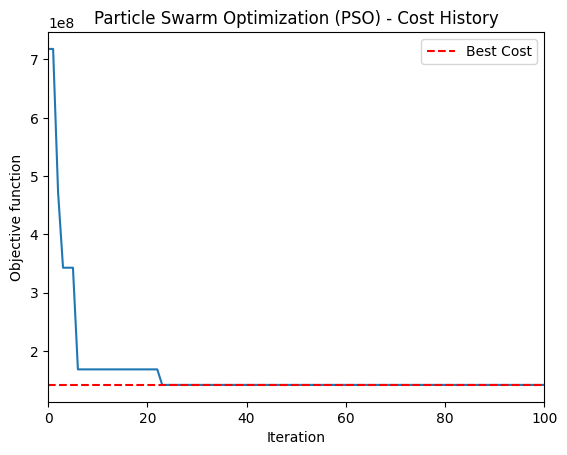

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 142014680.30857912
Tempo de Convergência: 1.638117790222168 segundos


In [51]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 1.000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

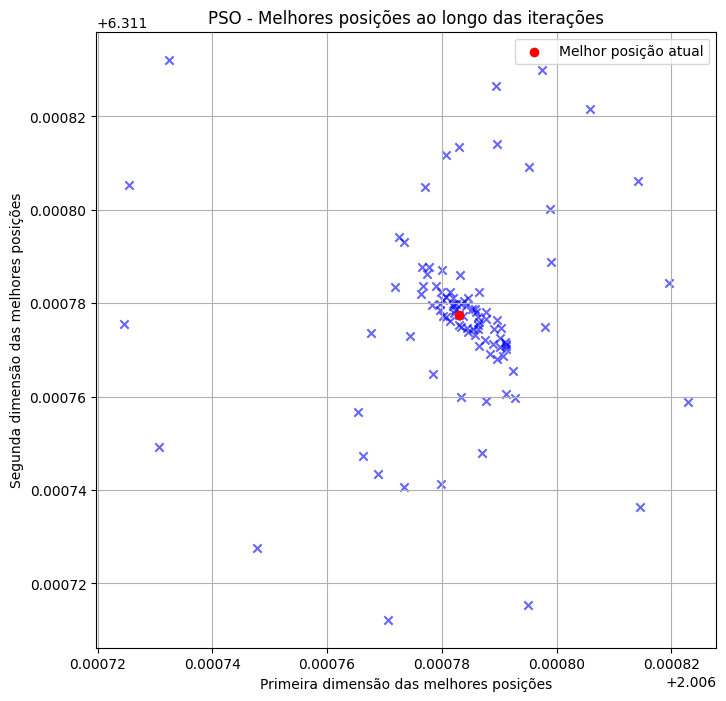

In [52]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [53]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
#nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_quarto_cenario.csv'

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor Custo', 'Lambda (λ)', 'Beta (β)', 'Theta (θ)', 'Número de ciclos de manutenção', 'Tempos para manutenções preventivas', 'Severidade para cada subsistema'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

NameError: ignored